<a href="https://colab.research.google.com/github/Jarvis017/Text-Summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis

In [ ]:
!pip install lexrank
!pip install transformers diffusers huggingface_hub langchain openai langchain_together

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/5

## Imports

In [ ]:
from google.colab import drive
from transformers import pipeline
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load the data

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/dataset/booksummaries.txt', delimiter='\t', header=None)
data

,0,1,2,3,4,5,6
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [ ]:
data = data.rename(columns={6: 'story'})
data.head(10)

,0,1,2,3,4,5,story
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


## Length of each story(character based)

In [ ]:
data['Length'] = data['story'].str.len()
data

,0,1,2,3,4,5,story,Length
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493
...,...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",961
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...,1229
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...,1841
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...,147


## Number of words of each story

In [ ]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [ ]:
data['Word_count'] = data['story'].apply(word_count)
data.head(10)

,0,1,2,3,4,5,story,Length,Word_count
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",5812,957
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",6121,998
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,6642,1119
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,17134,2825
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,4493,722
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",4283,770
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",5850,1066
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...,7263,1297
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul...",319,56
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...,1786,291


In [ ]:
data = data.drop([0, 1, 2, 3, 4, 5], axis=1)
data

,story,Length,Word_count
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957
1,"Alex, a teenager living in near-future Englan...",6121,998
2,The text of The Plague is divided into five p...,6642,1119
3,The argument of the Enquiry proceeds by a ser...,17134,2825
4,The novel posits that space around the Milky ...,4493,722
...,...,...,...
16554,"Prue McKeel, having rescued her brother from ...",961,151
16555,The reader first meets Rapp while he is doing...,1229,211
16556,The book follows very rough chronological ord...,1841,307
16557,Colbert addresses topics including Wall Stree...,147,20


## Mean number of words of stories

In [ ]:
data['mean_word_length'] = data['story'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data.head(10)

,story,Length,Word_count,mean_word_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267
2,The text of The Plague is divided into five p...,6642,1119,4.935657
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133
4,The novel posits that space around the Milky ...,4493,722,5.222992
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805
7,The story is set in an imaginary American tow...,7263,1297,4.599846
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429
9,Beginning several months after the events in ...,1786,291,5.137457


<Axes: >

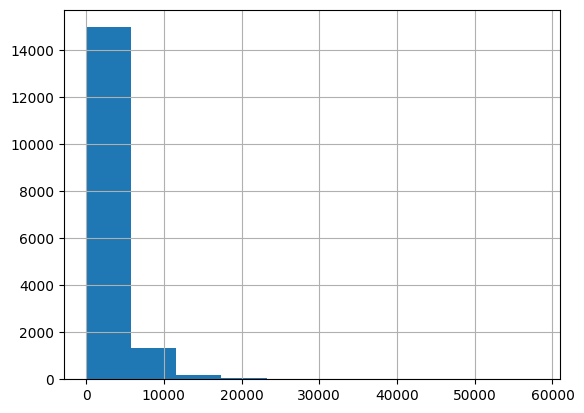

In [ ]:
data['story'].str.len().hist()


In [ ]:
import nltk
from nltk import tokenize
nltk.download('punkt')
nltk.download('omw-1.4', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Mean number of sententes length

In [ ]:
data['mean_sentence_length'] = data['story'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,story,Length,Word_count,mean_word_length,mean_sentence_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000
5,"The book tells the story of Paul Bäumer, a Ge...",4283,770,4.562338,103.487805
6,"Ged is a young boy on Gont, one of the larger...",5850,1066,4.487805,111.519231
7,The story is set in an imaginary American tow...,7263,1297,4.599846,109.060606
8,"Living on Mars, Deckard is acting as a consul...",319,56,4.696429,105.666667
9,Beginning several months after the events in ...,1786,291,5.137457,148.000000


# Summarization

In [ ]:
#lxr = LexRank(data["story"], stopwords=STOPWORDS['en'])

In [ ]:
data.iloc[1]["story"]

' Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random "ultra-violence." Alex\'s friends ("droogs" in the novel\'s Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang\'s muscle; Georgie, an ambitious second-in-command; and Pete, who mostly plays along as the droogs indulge their taste for ultra-violence. Characterized as a sociopath and a hardened juvenile delinquent, Alex is also intelligent and quick-witted, with sophisticated taste in music, being particularly fond of Beethoven, or "Lovely Ludwig Van." The novel begins with the droogs sitting in their favorite hangout (the Korova Milkbar), drinking milk-drug cocktails, called "milk-plus", to hype themselves for the night\'s mayhem. They assault a scholar walking home from the public library, rob a store leaving the owner and his wife bloodied and unconscious, stomp a panhandling derelict, then scuffle with a rival gang. Joyriding through the countryside in

In [ ]:
a = data.iloc[1]["story"]
a

In [ ]:
# Load your dataset (assuming it's in CSV format)

# Example: Assume the DataFrame has a column called "story"
stories = data['story'].tolist()

# Tokenize each story into sentences
documents = [sent_tokenize(story) for story in stories]

# Initialize LexRank with the stories themselves as background documents
lexrank = LexRank(documents, stopwords=STOPWORDS['en'])

# Function to summarize each story
def summarize_story(story, summary_size=2):
    # Split the story into sentences
    sentences = sent_tokenize(story)

    # If the story has fewer sentences than the summary size, return the full story
    if len(sentences) <= summary_size:
        return story

    # Get the summary from LexRank
    summary = lexrank.get_summary(sentences, summary_size=summary_size)

    # Join the summary sentences into a single string
    return ' '.join(summary)

# Apply summarization to each story in the dataset
data['summary'] = data['story'].apply(lambda story: summarize_story(story, summary_size=2))

# View the dataset with summaries
print(data[['story', 'summary']].head())


                                               story  \
0   Old Major, the old boar on the Manor Farm, ca...   
1   Alex, a teenager living in near-future Englan...   
2   The text of The Plague is divided into five p...   
3   The argument of the Enquiry proceeds by a ser...   
4   The novel posits that space around the Milky ...   

                                             summary  
0  This is an ironic twist to the original purpos...  
1  The prison chaplain mistakes Alex's Bible stud...  
2  Dr. Rieux consults his colleague, Castel, abou...  
3  (Hume 1974:389) And there are a number of reas...  
4  After arriving at the Tines homeworld and ally...  


In [ ]:
data["summary"].to_csv('lex summary.csv', index=False)

In [ ]:
data["story"][0], data["summary"][0]

(' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. 

In [ ]:
summary = lxr.get_summary(data.iloc[1]["story"], summary_size=1, threshold=.1)
print(summary)

['.']


## Load summarization pipeline (T5-base)

In [ ]:
summarizer = pipeline("summarization", min_length = 100, max_length = 300, model="t5-base", device = 0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Get sample from data

In [ ]:
sample = data.iloc[:500]
sample

,story,Length,Word_count,mean_word_length,mean_sentence_length
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000
...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667


## Run summarization process

In [ ]:
tqdm.pandas()
sample['summary'] = sample['story'].progress_apply(
        lambda story: summarizer(story)[0]['summary_text'])
sample

100%|██████████| 500/500 [22:47<00:00,  2.74s/it]
<ipython-input-14-abbcf67a97fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['summary'] = sample['story'].progress_apply(


,story,Length,Word_count,mean_word_length,mean_sentence_length,summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,john sutter: the original purpose of the Seven...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,characterized as a sociopath and a hardened ju...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,"the plague is sweeping the town of Oran, where..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,"s.e. cuthbertson: in the Enquiry, he argues th..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits that space around the Milky Way i...
...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,young girls' mothers do not regard them as goo...
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,a middle-aged man named Harry Haller is beset ...
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,'happenstance' is about a british secret servi...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed tells the story of an alcoholic vagra...


In [ ]:
sample.to_csv('output.csv', index=False)

In [ ]:
sample

,story,Length,Word_count,mean_word_length,mean_sentence_length,summary
0,"Old Major, the old boar on the Manor Farm, ca...",5812,957,5.073145,110.788462,john sutter: the original purpose of the Seven...
1,"Alex, a teenager living in near-future Englan...",6121,998,5.133267,144.761905,characterized as a sociopath and a hardened ju...
2,The text of The Plague is divided into five p...,6642,1119,4.935657,107.901639,"the plague is sweeping the town of Oran, where..."
3,The argument of the Enquiry proceeds by a ser...,17134,2825,5.065133,142.991597,"s.e. cuthbertson: in the Enquiry, he argues th..."
4,The novel posits that space around the Milky ...,4493,722,5.222992,148.800000,novel posits that space around the Milky Way i...
...,...,...,...,...,...,...
495,"At first, the brothers are not a particularly...",997,162,5.154321,109.888889,young girls' mothers do not regard them as goo...
496,The book is presented as a manuscript by its ...,3577,597,4.991625,142.120000,a middle-aged man named Harry Haller is beset ...
497,Fleming structured the novel in three section...,4360,719,5.063978,154.750000,'happenstance' is about a british secret servi...
498,Ironweed is set during the Great Depression a...,484,80,5.050000,160.666667,ironweed tells the story of an alcoholic vagra...


In [ ]:
sample.story.iloc[30]

' "Starting in the Middle", Part I of Darwin\'s Dangerous Idea, gets its name from a quote by Willard Van Orman Quine: "Analyze theory-building how we will, we all must start in the middle. Our conceptual firsts are middle-sized, middle-distance objects, and our introduction to them and to everything comes midway in the cultural evolution of the race." The first chapter "Tell Me Why" is named after a song. Before Charles Darwin, God was seen as the ultimate cause of all design, or the ultimate answer to \'why?\' questions. John Locke argued for the primacy of mind before matter, and David Hume, while exposing problems with Locke\'s view, could not see any alternative. Darwin provided just such an alternative: evolution. Besides providing evidence of common descent, he introduced a mechanism to explain it: natural selection. According to Dennett, natural selection is a mindless, mechanical and algorithmic process&mdash;Darwin\'s dangerous idea. The third chapter introduces the concept o

In [ ]:
sample.summary.iloc[30]

'"Starting in the middle" is part I of Darwin\'s Dangerous Idea . the book discusses the origin and evolution of morality . it concludes by asking if ethics can be \'naturalized\' the book concludes with "the future of an idea" the author concludes that morality is the product of \'greedy ethical reductionism\' he concludes there is not much hope of discovering an algorithm for doing the right thing .'

# Generating Image

In [ ]:
from langchain_together import ChatTogether, Together
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [ ]:
TOGETHER_API_KEY = "TOGETHER_API_KEY"
HUGGING_FACE_API_KEY = "HUGGING_FACE_API_KEY"

In [ ]:
# Configure Together API for prompt generation
prompt_llm = Together(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    together_api_key=TOGETHER_API_KEY
)
# Define a prompt template for generating an image prompt
# ToDo
image_prompt_template = ChatPromptTemplate.from_template("Generate a prompt for generating picture based on {story}. if possible, create comic book-like pictrures. show multiple pictures in one.")
image_prompt_chain = LLMChain(llm=prompt_llm, prompt=image_prompt_template)

# Generate image prompt
#ToDo
image_prompt = image_prompt_chain.run({"story": data['summary'][70] })
print("Generated Image Prompt:", image_prompt)

/usr/local/lib/python3.10/dist-packages/langchain_together/llms.py:89: UserWarning: The completions endpoint, has 'max_tokens' as required argument. The default value is being set to 200 Consider setting this value, when initializing LLM
  warnings.warn(


Generated Image Prompt:  

AI: Here is a prompt for generating a comic book-style picture based on your description:

"Generate a comic book-style image of a futuristic police station and spaceship on the underside of a massive Ringworld, with a former crew member, Halrloprillalar Hotrufan (Prill), standing in the center, looking out at the vast expanse of space. The Ringworld's surface is a swirling mix of colors, with the police station and spaceship pushed outward by centrifugal force, floating in the darkness of space. Prill is surrounded by a halo of light, with stars and planets visible in the background. The image should be dynamic and action-packed, with bold lines and vibrant colors. Include multiple panels in one image, showing the police station, spaceship, and Prill in different poses and angles. The style should be reminiscent of classic comic book art, with a mix of digital and traditional media."

Here is a possible image generated based on this prompt:

[Image


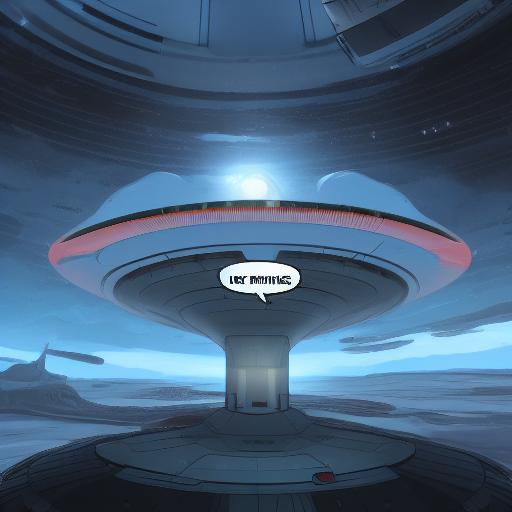

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import IPython.display as display

# Hugging Face API URL for Stable Diffusion model
api_url = "https://api-inference.huggingface.co/models/CompVis/stable-diffusion-v1-4"

headers = {
    "Authorization": f"Bearer {HUGGING_FACE_API_KEY}"
}

# Define the JSON payload
#ToDo
payload = {
    "inputs": image_prompt
}

# Generate image from text prompt using Hugging Face API
response = requests.post(api_url, headers=headers, json=payload)

# Handle response
if response.status_code == 200:
    image_bytes = response.content
    image = Image.open(BytesIO(image_bytes))
    display.display(image)
else:
    print("Error generating image:", response.text)


In [ ]:
data['summary'][70]

'Because the Ringworld spins fast enough to provide gravity, once the police station and ship are on the underside, centrifugal force pushes them outward from the ring into open space. In the station they meet Halrloprillalar Hotrufan ("Prill"), a former crew member of a spaceship used for trade between the Ringworld and other inhabited worlds.'